In [1]:
import json

import pandas as pd

df = pd.concat([
    pd.read_parquet('verified/rebalanced/output/verified-train.parquet'),
    pd.read_parquet('verified/rebalanced/output/verified-val.parquet'),
    pd.read_parquet('verified/rebalanced/output/verified-test.parquet')
])

df.head(3)

,id,label_age,analysis_age,label_disability,analysis_disability,label_feminine,analysis_feminine,label_general,analysis_general,label_masculine,...,label_neutral,analysis_neutral,label_racial,analysis_racial,label_sexuality,analysis_sexuality,verified,synthetic,text,metadata
1589,Kaggle::techmap::613fb0a3ff961119564fb566::see...,False,None,False,None,True,"""A feminist approach and perspective"" could be...",False,None,False,...,False,None,False,None,False,None,True,False,Marys House Services Limited is a not-for-prof...,"{""document_id"": ""Kaggle::techmap::613fb0a3ff96..."
1881,Kaggle::techmap::614619712942e66f10984e4a::lin...,True,"The phrase ""10 years' experience working on Da...",False,None,False,None,False,None,False,...,False,None,False,None,False,None,True,False,10 years' experience working on Data Warehousi...,"{""document_id"": ""Kaggle::techmap::614619712942..."
1153,Kaggle::techmap::61541a294d292d07bb183f52::hea...,True,Some of the language is biased against younger...,False,None,False,None,False,None,False,...,False,None,False,None,False,None,True,False,"Head of Legal Support, Commercial Functions\n\...","{""document_id"": ""Kaggle::techmap::61541a294d29..."


In [2]:
print(f"Column Names: {df.columns}")
print(f"Columns: {len(df.columns)}")
print(f"Rows: {len(df)}")

Column Names: Index(['id', 'label_age', 'analysis_age', 'label_disability',
       'analysis_disability', 'label_feminine', 'analysis_feminine',
       'label_general', 'analysis_general', 'label_masculine',
       'analysis_masculine', 'label_neutral', 'analysis_neutral',
       'label_racial', 'analysis_racial', 'label_sexuality',
       'analysis_sexuality', 'verified', 'synthetic', 'text', 'metadata'],
      dtype='object')
Columns: 21
Rows: 2616


In [3]:
label_columns = [col for col in df.columns if col.startswith('label_')]
analysis_columns = [col for col in df.columns if col.startswith('analysis_')]
categories = [col.replace('label_', '') for col in label_columns]
text_column = 'text'

print(f"Categories: {categories}")
print(f"Labels: {label_columns}")
print(f"Analysis: {analysis_columns}")
print(f"Input: {text_column}")

print(f"\nRows: {len(df)}")
for category in categories:
    label = f"label_{category}"
    bias = len(df[df[label] == True])
    unbiased = len(df[df[label] == False])
    print(f"\t{category}: {bias} biased, {unbiased} unbiased")

non_neutral = df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
neutral = df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()
print(f'\tHas at least one bias category: {non_neutral} ({non_neutral / len(df):.2%})')
print(f'\tHas no bias categories: {neutral} ({neutral / len(df):.2%})')


Categories: ['age', 'disability', 'feminine', 'general', 'masculine', 'neutral', 'racial', 'sexuality']
Labels: ['label_age', 'label_disability', 'label_feminine', 'label_general', 'label_masculine', 'label_neutral', 'label_racial', 'label_sexuality']
Analysis: ['analysis_age', 'analysis_disability', 'analysis_feminine', 'analysis_general', 'analysis_masculine', 'analysis_neutral', 'analysis_racial', 'analysis_sexuality']
Input: text

Rows: 2616
	age: 201 biased, 2415 unbiased
	disability: 203 biased, 2413 unbiased
	feminine: 194 biased, 2422 unbiased
	general: 204 biased, 2412 unbiased
	masculine: 198 biased, 2418 unbiased
	neutral: 1352 biased, 1264 unbiased
	racial: 194 biased, 2422 unbiased
	sexuality: 201 biased, 2415 unbiased
	Has at least one bias category: 2616 (100.00%)
	Has no bias categories: 0 (0.00%)


In [4]:
metadata_columns = ['document_id', 'country', 'source', 'company', 'position']

for col in metadata_columns:
    df[col] = None

for idx, sample in df.iterrows():
    j = sample['metadata']
    md = json.loads(j)
    if sample['synthetic']:
        m = md.get('model').split(':')[-1]
        m = m.lower()
        if 'llama' in m:
            m = 'llama-3-70b'
        elif 'gpt-4o' in m:
            m = 'gpt-4o'
        df.at[idx, 'type'] = m
    else:
        df.at[idx, 'type'] = 'Real'
        for col in metadata_columns:
            df.at[idx, col] = md.get(col)

In [5]:
df.head(10)

,id,label_age,analysis_age,label_disability,analysis_disability,label_feminine,analysis_feminine,label_general,analysis_general,label_masculine,...,verified,synthetic,text,metadata,document_id,country,source,company,position,type
1589,Kaggle::techmap::613fb0a3ff961119564fb566::see...,False,None,False,None,True,"""A feminist approach and perspective"" could be...",False,None,False,...,True,False,Marys House Services Limited is a not-for-prof...,"{""document_id"": ""Kaggle::techmap::613fb0a3ff96...",Kaggle::techmap::613fb0a3ff961119564fb566::see...,AU,seek_au,Mary's House Services Limited,Senior Domestic Violence Caseworker,Real
1881,Kaggle::techmap::614619712942e66f10984e4a::lin...,True,"The phrase ""10 years' experience working on Da...",False,None,False,None,False,None,False,...,True,False,10 years' experience working on Data Warehousi...,"{""document_id"": ""Kaggle::techmap::614619712942...",Kaggle::techmap::614619712942e66f10984e4a::lin...,PT,linkedin_pt,IQVIA,BI/ Architect,Real
1153,Kaggle::techmap::61541a294d292d07bb183f52::hea...,True,Some of the language is biased against younger...,False,None,False,None,False,None,False,...,True,False,"Head of Legal Support, Commercial Functions\n\...","{""document_id"": ""Kaggle::techmap::61541a294d29...",Kaggle::techmap::61541a294d292d07bb183f52::hea...,RU,headhunter_ru,HAYS,Head of Legal Support – Commercial Functions,Real
192,Kaggle::techmap::61464b6fb8f6167d193d8202::lin...,True,"The term ""Social Media savvy"" implies a prefer...",False,None,False,None,False,None,True,...,True,False,3 Years experience in travel companies busines...,"{""document_id"": ""Kaggle::techmap::61464b6fb8f6...",Kaggle::techmap::61464b6fb8f6167d193d8202::lin...,CZ,linkedin_cz,Multireisen Deutschland MRD GmbH Groups,SM Tech –Sales Tech Manager Prague,Real
226,Kaggle::techmap::614129a68be8df1fa24b57c0::car...,False,None,False,None,False,None,True,"Stating a requirement for an ""Undergraduate de...",False,...,True,False,Ref ID: 00720-0011852850 \nClassification: Sr...,"{""document_id"": ""Kaggle::techmap::614129a68be8...",Kaggle::techmap::614129a68be8df1fa24b57c0::car...,US,careerbuilder_us,Robert Half,CPG - Senior Accountant,Real
115,Kaggle::techmap::6144b4a17ea9bc0ff35126c0::see...,True,"""A role that will keep you active and fit"" cou...",True,"""A role that will keep you active and fit"" cou...",False,None,False,None,False,...,True,False,About the business:\nCredo is a thriving and v...,"{""document_id"": ""Kaggle::techmap::6144b4a17ea9...",Kaggle::techmap::6144b4a17ea9bc0ff35126c0::see...,AU,seek_au,Credo National 2 Pty Ltd,General Hands - Day & Night Shift- Logan and S...,Real
1080,Kaggle::techmap::614f3eaea2141e01bdd3ba83::lin...,True,"The requirement of ""10 years experience"" can i...",False,None,True,The phrase specifically encouraging applicatio...,False,None,False,...,True,False,10 years experience in developing and supporti...,"{""document_id"": ""Kaggle::techmap::614f3eaea214...",Kaggle::techmap::614f3eaea2141e01bdd3ba83::lin...,ID,linkedin_id,Abt Associates,Communications Manager,Real
293,Kaggle::techmap::61551169aff3ff560f504c8f::see...,False,None,True,"The phrase ""must be physically fit, healthy"" s...",False,None,False,None,True,...,True,False,Seasons Funeral Homes are a recognised industr...,"{""document_id"": ""Kaggle::techmap::61551169aff3...",Kaggle::techmap::61551169aff3ff560f504c8f::see...,AU,seek_au,Vitil,Funeral Director's Assistant,Real
86,Kaggle::techmap::616f5c7e210ee81bafb85c28::lin...,True,"The phrase ""fast-based"" could be seen as impli...",False,None,False,None,False,None,False,...,True,False,"South Raleigh\n\nUnder general supervision, Ad...","{""document_id"": ""Kaggle::techmap::616f5c7e210e...",Kaggle::techmap::616f5c7e210ee81bafb85c28::lin...,IE,linkedin_ie,Strayer University,Admissions Officer,Real
1082,Kaggle::techmap::615b40deacc0784495a5927a::sna...,False,None,True,None,False,None,False,None,False,...,True,False,Description:\n\nAngels of Care Pediatric Home ...,"{""d

In [6]:
import json

documents = set()
phrases = set()
countries = set()
websites = set()
companies = set()
roles = set()
synthetics = set()
real = set()

for idx, sample in df.iterrows():
    phrases.add(sample['id'])
    if sample['synthetic']:
        synthetics.add(sample['id'])
    else:
        real.add(sample['id'])
        j = sample['metadata']
        md = json.loads(j)
        documents.add(md['document_id'])
        countries.add(md['country'])
        websites.add(md['source'])
        companies.add(md['company'])
        roles.add(md['position'])

print(f"Documents: {len(documents)}")
print(f"Phrases: {len(phrases)}")
print(f"Countries: {len(countries)}")
print(f"Websites: {len(websites)}")
print(f"Companies: {len(companies)}")
print(f"Roles: {len(roles)}")

Documents: 785
Phrases: 2616
Countries: 66
Websites: 108
Companies: 688
Roles: 764


In [7]:
import pandas as pd


def value_stats(dataframe, column, format_counts=True):
    counts = dataframe[column].value_counts()
    percentages = (dataframe[column].value_counts(normalize=True) * 100).round(2)

    dataframe = pd.DataFrame({'Count': counts, 'Percentage': percentages.astype(str) + '%'})

    if format_counts:
        dataframe['Count'] = dataframe['Count'].apply('{:,}'.format)
    return dataframe


In [8]:
df_real = df[df['synthetic'] == False]
print(f'Real samples: {len(df_real)}')

Real samples: 787


In [9]:
df_real.head(3)

,id,label_age,analysis_age,label_disability,analysis_disability,label_feminine,analysis_feminine,label_general,analysis_general,label_masculine,...,verified,synthetic,text,metadata,document_id,country,source,company,position,type
1589,Kaggle::techmap::613fb0a3ff961119564fb566::see...,False,None,False,None,True,"""A feminist approach and perspective"" could be...",False,None,False,...,True,False,Marys House Services Limited is a not-for-prof...,"{""document_id"": ""Kaggle::techmap::613fb0a3ff96...",Kaggle::techmap::613fb0a3ff961119564fb566::see...,AU,seek_au,Mary's House Services Limited,Senior Domestic Violence Caseworker,Real
1881,Kaggle::techmap::614619712942e66f10984e4a::lin...,True,"The phrase ""10 years' experience working on Da...",False,None,False,None,False,None,False,...,True,False,10 years' experience working on Data Warehousi...,"{""document_id"": ""Kaggle::techmap::614619712942...",Kaggle::techmap::614619712942e66f10984e4a::lin...,PT,linkedin_pt,IQVIA,BI/ Architect,Real
1153,Kaggle::techmap::61541a294d292d07bb183f52::hea...,True,Some of the language is biased against younger...,False,None,False,None,False,None,False,...,True,False,"Head of Legal Support, Commercial Functions\n\...","{""document_id"": ""Kaggle::techmap::61541a294d29...",Kaggle::techmap::61541a294d292d07bb183f52::hea...,RU,headhunter_ru,HAYS,Head of Legal Support – Commercial Functions,Real


In [10]:
value_stats(df_real, 'country')

,Count,Percentage
country,,
US,198,25.16%
UK,105,13.34%
AU,54,6.86%
CA,32,4.07%
RU,31,3.94%
...,...,...
BO,1,0.13%
UY,1,0.13%
LT,1,0.13%


In [11]:
value_stats(df_real, 'source')

,Count,Percentage
source,,
careerbuilder_us,68,8.64%
seek_au,54,6.86%
aarp_us,41,5.21%
reed_uk,34,4.32%
britishjobs_uk,32,4.07%
...,...,...
linkedin_hn,1,0.13%
monster2_fr,1,0.13%
monster2_ca,1,0.13%


In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import json


def plot_by_category(dataframe, x_ideal=200):
    melted_df = dataframe.melt(id_vars='type', value_vars=label_columns, var_name='categories')
    melted_df = melted_df[melted_df['value'] == 1]

    real_df = dataframe[dataframe['synthetic'] == False]
    synthetic_df = dataframe[dataframe['synthetic'] == True]
    gpt4_df = dataframe[dataframe['type'] == 'gpt-4o']
    llama3_df = dataframe[dataframe['type'] == 'llama-3-70b']

    non_neutral_real = real_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_real = real_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()

    non_neutral_synthetic = synthetic_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_synthetic = synthetic_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()

    gpt4o_synthetic = gpt4_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    llama3_synthetic = llama3_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()

    total_real_str = '{:,.0f}'.format(len(real_df))
    total_synthetic_str = '{:,.0f}'.format(len(synthetic_df))
    total_gpt4o_str = '{:,.0f}'.format(len(gpt4_df))
    total_llama3_str = '{:,.0f}'.format(len(llama3_df))

    pivot_df = melted_df.pivot_table(index='categories', columns='type', aggfunc='size', fill_value=0)
    pivot_df.index = pivot_df.index.str.replace('label_', '')
    pivot_df = pivot_df.sort_values(by='Real', ascending=True)
    #pivot_df = pivot_df.rename(columns={True: 'Synthetic', False: 'Real'})

    plt.figure(figsize=(25, 25))
    #color=['#6495ED', '#FFA500', '#32CD32']
    bar_plot = pivot_df.plot(kind='barh', stacked=True, color=['#027eb5', '#ff9457', '#56c596'])
    
    total_values = pivot_df.sum(axis=1)

    for index, value in enumerate(total_values):
        plt.text(800, index,
                 f' {value}',
                 verticalalignment='center',
                 fontsize=16)

    #plt.title('Verified Biased Job Descriptions', fontsize=18)
    plt.xlabel('', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

    plt.legend([f'{total_real_str} Real', f'{total_gpt4o_str} GPT-4o', f'{total_llama3_str} Llama3-70B'], loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=16, title='')


    for rect in bar_plot.patches:
        width, height = rect.get_width(), rect.get_height()
        x, y = rect.get_xy()
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:.0f}'.format(width),
                      ha='center',
                      va='center',
                      color='000000',
                      weight='bold',
                      fontsize=18)

    # Set x limit 25% more than max value
    plt.xlim(0, 730)

    # Draw a vertical line at x = 200
    if x_ideal:
        plt.axvline(x=x_ideal, color="red", linestyle='--')

    plt.show()


def plot_neutral_vs_bias(dataframe):
    real_df = dataframe[dataframe['synthetic'] == False]
    synthetic_df = dataframe[dataframe['synthetic'] == True]
    llama_df = dataframe[dataframe['type'] == True]

    non_neutral_real = real_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_real = real_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()

    non_neutral_synthetic = synthetic_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_synthetic = synthetic_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()

    #print(f'non neutral synthetic: {non_neutral_synthetic}')
    #print(f'non neutral real: {non_neutral_real}')
    #print(f'neutral synthetic: {neutral_synthetic}')
    #print(f'neutral real: {neutral_real}')

    total_real_str = '{:,.0f}'.format(non_neutral_real + neutral_real)
    total_synthetic_str = '{:,.0f}'.format(non_neutral_synthetic + neutral_synthetic)
    neutral_str = '{:,.0f} Neutral'.format(neutral_synthetic + neutral_real)
    bias_cont_str = '{:,.0f} Bias'.format(non_neutral_synthetic + non_neutral_real)
    total_str = '{:,.0f}'.format(non_neutral_synthetic + neutral_synthetic + neutral_real + non_neutral_real)

    data = {'Category': [bias_cont_str, bias_cont_str, neutral_str, neutral_str],
            'Count': [non_neutral_synthetic, non_neutral_real, neutral_synthetic, neutral_real],
            'synthetic': ['Synthetic', 'Real', 'Synthetic', 'Real']}
    synth_df = pd.DataFrame(data)

    plt.figure(figsize=(20, 10))

    bar_plot = synth_df['Count'].groupby([synth_df['Category'], synth_df['type']]).sum().unstack().plot.barh(
        stacked=True, color=['#6495ED', '#FFA500', '#228B22'])

    plt.title(f'{total_str} Verified Job Descriptions', fontsize=18)
    plt.xlabel('', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.legend([
        f'{total_real_str} Real',
        f'{total_synthetic_str} Synthetic'
    ],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='')

    patches = bar_plot.patches
    values = [non_neutral_real, neutral_real, non_neutral_synthetic, neutral_synthetic]

    # Display values for each segment
    for patch, value in zip(patches, values):
        width, height = patch.get_width(), patch.get_height()
        x, y = patch.get_xy()
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:,.0f}'.format(value),
                      ha='center',
                      va='center',
                      color='black',
                      fontsize=18)

    plt.show()


def plot_by_models(dataframe):
    dataframe = dataframe[dataframe['synthetic'] == True]

    models = {}

    for meta in dataframe['metadata']:
        meta = json.loads(meta)
        model_name = meta['model']
        model_name = model_name.split(':')[-1]
        if model_name not in models:
            models[model_name] = 1
        else:
            models[model_name] += 1

    dataframe = pd.DataFrame(list(models.items()), columns=['Model', 'Count'])

    #model_names = dataframe['Model']
    model_counts = dataframe['Count']

    plt.figure(figsize=(10, 5))

    bar_plot = dataframe['Count'].groupby(dataframe['Model']).sum().plot.barh(color='#6495ED')

    plt.title('Verified Synthetic Job Descriptions', fontsize=18)
    plt.xlabel('', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

    patches = bar_plot.patches

    # Display values for each segment
    for patch, count in zip(patches, model_counts):
        width, height = patch.get_width(), patch.get_height()
        x, y = patch.get_xy()
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:,.0f}'.format(count),
                      ha='center',
                      va='center',
                      color='black',
                      fontsize=18)
    plt.show()

<Figure size 1800x1800 with 0 Axes>

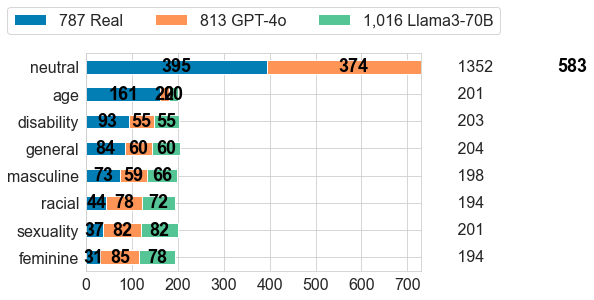

In [13]:
plot_by_category(df, None)

In [14]:
plot_neutral_vs_bias(df)

KeyError: 'type'

<Figure size 1440x720 with 0 Axes>

In [ ]:
plot_by_models(df)

High entropy indicates that the label distribution is fairly uniform, and no single label dominates.
This suggests a balanced dataset.

The maximum entropy occurs when all labels are equally probable.
The maximum entropy can be calculated using the formula: log_2(n)

In [15]:
import numpy as np

# Calculate entropy for labels in dataset.
# Source: https://colab.research.google.com/drive/1pddMaJJIHR0O8MND42hfzYRxOPMV82KA?usp=sharing#scrollTo=RkVuiK_loty4

def categorical_entropy(df: pd.DataFrame, labels: list):
    # Calculate frequency for each label 
    label_frequency = df[labels].sum()

    # Calculate probabilities for each label
    label_probabilities = label_frequency / label_frequency.sum()

    # Calculate entropy
    entropy = -np.sum(label_probabilities * np.log2(label_probabilities))

    return entropy

In [32]:

labels = ['label_age', 'label_disability', 'label_feminine', 'label_general', 'label_masculine', 'label_racial', 'label_sexuality']
null_label = 'label_neutral'

In [38]:

import math

max_entropy = math.log2(len(labels))
print(f"Maximum Entropy Possible: {max_entropy}")

Maximum Entropy Possible: 1.0


In [34]:
# entropy for original dataset
categorical_entropy(df, labels)

2.807096335498576

In [36]:
import pandas as pd
import numpy as np

def calc_entropy_with_null_label(df: pd.DataFrame, labels: list, null_label: str):
        
    # Calculate frequencies for the primary labels
    label_frequency = df[labels].sum()
    
    # Calculate the probability for each primary label
    total_instances = len(df)
    label_probabilities = label_frequency / label_frequency.sum()

    # Calculate entropy for primary labels
    primary_entropy = -np.sum(label_probabilities * np.log2(label_probabilities + 1e-9))  # Adding a small value to avoid log(0)

    # Calculate the probability of the null label
    null_label_prob = (df[labels].sum(axis=1) == 0).mean()  # Probability of the null label being 1
    non_null_label_prob = 1 - null_label_prob  # Probability of the null label being 0
    
    print(null_label_prob)
    print(non_null_label_prob)

    # Calculate entropy for the null label
    null_label_entropy = -(null_label_prob * np.log2(null_label_prob + 1e-9) + non_null_label_prob * np.log2(non_null_label_prob + 1e-9))

    print(primary_entropy)
    print(null_label_entropy)
    # Total entropy is the sum of primary labels' entropy and null label entropy
    total_entropy = primary_entropy + null_label_entropy

    return total_entropy



entropy = calc_entropy_with_null_label(df, labels, null_label)
print(f"Entropy: {entropy}")


0.5168195718654435
0.4831804281345565
2.807096335498576
0.9991835720204252
Entropy: 3.8062799075190012


In [43]:
import numpy as np

def max_entropy_with_null_label(num_primary_labels: int):
    # Calculate the maximum entropy for primary labels
    max_primary_entropy = num_primary_labels  # Each primary label has a max entropy of 1 bit

    # Calculate the probability of the null label
    null_label_prob = (1 / 2) ** num_primary_labels  # Probability of all primary labels being 0
    non_null_label_prob = 1 - null_label_prob  # Probability of at least one primary label being 1
    
    # Calculate entropy for the null label
    null_label_entropy = -(null_label_prob * np.log2(null_label_prob + 1e-9) + non_null_label_prob * np.log2(non_null_label_prob + 1e-9))
    
    # Total entropy is the sum of maximum entropy of primary labels and entropy of the null label
    total_entropy = max_primary_entropy + null_label_entropy

    return total_entropy

# Example usage
num_primary_labels = 7
max_entropy = max_entropy_with_null_label(num_primary_labels)
print(f"Maximum Entropy with {num_primary_labels} primary labels and 1 null label: {max_entropy}")


Maximum Entropy with 7 primary labels and 1 null label: 7.065914409457852


In [5]:
import pandas as pd
import numpy as np

def calc_entropy_with_null_label(df: pd.DataFrame, labels: list, null_label: str):
    total_instances = len(df)
    
    # Calculate the probability for each primary label
    label_probabilities = df[labels].mean()
    
    # Calculate entropy for primary labels
    primary_entropy = -np.sum(label_probabilities * np.log2(label_probabilities + 1e-9) + (1 - label_probabilities) * np.log2((1 - label_probabilities) + 1e-9))
    
    # Calculate the probability of the null label
    null_label_prob = (df[labels].sum(axis=1) == 0).mean()  # Probability of the null label being 1
    non_null_label_prob = 1 - null_label_prob  # Probability of the null label being 0
    
    # Calculate entropy for the null label
    null_label_entropy = -(null_label_prob * np.log2(null_label_prob + 1e-9) + non_null_label_prob * np.log2(non_null_label_prob + 1e-9))
    
    # Total entropy is the sum of primary labels' entropy and null label entropy
    total_entropy = primary_entropy + null_label_entropy

    return total_entropy


#entropy = calc_entropy_with_null_label(df, labels, null_label)
#print(f"Entropy: {entropy}")


NameError: name 'df' is not defined

In [17]:
from skmultilearn.dataset import load_dataset

# Load the Emotions dataset
X_train, y_train, feature_names, label_names = load_dataset('emotions', 'train')

# Create the null label
import numpy as np
null_label = np.where(y_train.toarray().sum(axis=1) == 0, 1, 0)

# Add the null label to the dataset
y_train = np.hstack((y_train.toarray(), null_label.reshape(-1, 1)))

new_column_names = {0: 'a', 1: 'b', 2: 'c',3:'d',4:'e',5:'f',6:'g'}

# Rename columns by index
y_train.rename(columns=new_column_names, inplace=True)


y_train

emotions:train - exists, not redownloading


AttributeError: 'numpy.ndarray' object has no attribute 'rename'

In [2]:
!pip install arff

  Preparing metadata (setup.py) ... done
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4950 sha256=a661895862191c8c2e88e4b161a3ad8d895f57200e97b14a1e86936f372f50c6
  Stored in directory: /home/teveritt/.cache/pip/wheels/0c/39/12/4d8ff491018bce2dd9cc6034298f27399c7f4fd4063187f7be
Successfully built arff

[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [8]:
y_train['0','1','2','3','4','5']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [12]:
calc_entropy_with_null_label(y_train,label_columns,'null_label')

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]